In [9]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [3]:
trd = pd.read_csv('train.csv')
tsd = pd.read_csv('test.csv')
td = pd.concat([trd, tsd], ignore_index=True, sort = False)


Text(0.5, 1.0, 'Missing values heatmap')

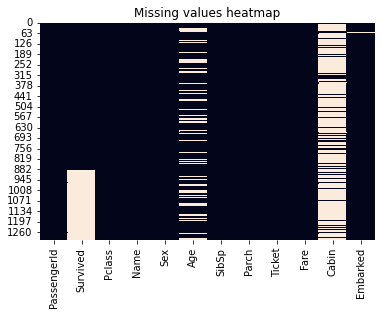

In [4]:
td.isnull().sum()
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")

In [6]:
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid', 'High_Mid','High'])

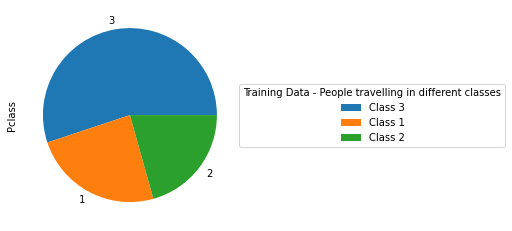

In [10]:
fig_pclass = trd.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("Training Data - People travelling in different classes")

In [11]:
print(trd.Pclass.value_counts())

3    491
1    216
2    184
Name: Pclass, dtype: int64


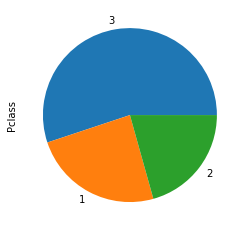

In [12]:
fig_pclass = trd.Pclass.value_counts().plot.pie()


Text(0.5, 1.0, 'Training Data - Percentage of people survived on the basis of class')

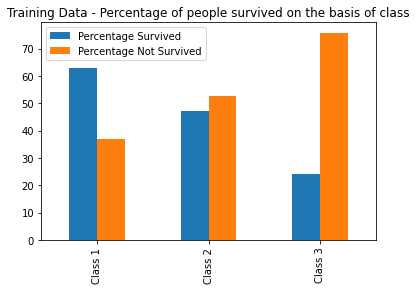

In [14]:
pclass_1_survivor_distribution = round((trd[trd.Pclass == 1].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 1]) * 100, 2)
pclass_2_survivor_distribution = round((trd[trd.Pclass == 2].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 2]) * 100, 2)
pclass_3_survivor_distribution = round((trd[trd.Pclass == 3].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 3]) * 100, 2)
pclass_perc_df = pd.DataFrame(
    { "Percentage Survived":{"Class 1": pclass_1_survivor_distribution,"Class 2": pclass_2_survivor_distribution, "Class 3": pclass_3_survivor_distribution},  
     "Percentage Not Survived":{"Class 1": 100-pclass_1_survivor_distribution,"Class 2": 100-pclass_2_survivor_distribution, "Class 3": 100-pclass_3_survivor_distribution}})
pclass_perc_df.plot.bar().set_title("Training Data - Percentage of people survived on the basis of class")



In [31]:
first_class = trd.Pclass == 1
fc_survived = trd[first_class].Survived == 1
women = trd[fc_survived].Sex == "female"
print(fc_survived.value_counts())
print(women.value_counts())

<ipython-input-31-296a5152dc7f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  women = trd[fc_survived].Sex == "female"


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [32]:
print (trd.notnull().any(axis = 0))

PassengerId    True
Survived       True
Pclass         True
Name           True
Sex            True
Age            True
SibSp          True
Parch          True
Ticket         True
Fare           True
Cabin          True
Embarked       True
dtype: bool


In [33]:
df = trd.loc[:, trd.notnull().any(axis = 0)]
print (df)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [40]:
trd.loc[
    (trd['Pclass'] == 1) &
    (trd['Sex'] == 'female') & 
    (trd['Survived'] == 1)
]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
31,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
...,...,...,...,...,...,...,...,...,...,...,...,...
856,857,1,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C


In [43]:
trd[
    (trd['Pclass'] == 2) &
    (trd['Sex'] == 'female') & 
    (trd['Survived'] == 1)
].value_counts()

PassengerId  Survived  Pclass  Name                                          Sex     Age   SibSp  Parch  Ticket           Fare     Cabin  Embarked
718          1         2       Troutt, Miss. Edwina Celia "Winnie"           female  27.0  0      0      34218            10.5000  E101   S           1
619          1         2       Becker, Miss. Marion Louise                   female  4.0   2      1      230136           39.0000  F4     S           1
517          1         2       Lemore, Mrs. (Amelia Milley)                  female  34.0  0      0      C.A. 34260       10.5000  F33    S           1
474          1         2       Jerwan, Mrs. Amin S (Marie Marthe Thuillard)  female  23.0  0      0      SC/AH Basle 541  13.7917  D      C           1
346          1         2       Brown, Miss. Amelia "Mildred"                 female  24.0  0      0      248733           13.0000  F33    S           1
328          1         2       Ball, Mrs. (Ada E Hall)                       female  36.0  0 

In [44]:
trd.loc[
    (trd['Pclass'] == 3) &
    (trd['Sex'] == 'female') & 
    (trd['Survived'] == 1)
]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
823,824,1,3,"Moor, Mrs. (Beila)",female,27.0,0,1,392096,12.4750,E121,S
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.0,1,0,2659,14.4542,NaN,C
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
858,859,1,3,"Baclini, Mrs. Solomon (Latifa Qurban)",female,24.0,0,3,2666,19.2583,NaN,C
